In [38]:
import torch
import torchvision
import matplotlib.pyplot as plt

from time import time

In [3]:
# MNIST : hello world
# EMNIST : extended with letters in addition to digits
# KMNIST : Kuzushiji, Japanese characters
# QMNIST : newer MNIST with better source information

data_path = "../data/"

mnist_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root=data_path, train=True, download=True, transform=mnist_transforms
)

/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset)

In [6]:
num_pixels = 28 * 28

w = torch.randn(num_pixels, 1)
b = torch.randn(1)

In [25]:
x, y = next(iter(train_loader))

z = w.T @ x.view(num_pixels, 1) + b
a = torch.sigmoid(z)

yhat = a
yhat

tensor([[2.5431e-21]])

In [27]:
loss = (yhat - y)**2

In [22]:
# Get down to two classes (let them pick)

class1 = 4
class2 = 7

idx1 = [i for i, t in enumerate(train_dataset.targets) if t == class1]
idx2 = [i for i, t in enumerate(train_dataset.targets) if t == class2]

idxs = idx1 + idx2
train_size = len(idxs)

train_loader2 = torch.utils.data.DataLoader(
    train_dataset, sampler=torch.utils.data.SubsetRandomSampler(idxs)
)

In [35]:
train_size

12107

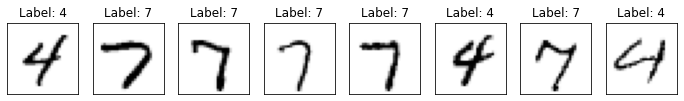

In [24]:
num_to_show = 8

fig, axes = plt.subplots(1, num_to_show, figsize=(12, 12))

for axis, (image, label) in zip(axes, train_loader2):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_title(f"Label: {label[0]}")

In [41]:
# Optimization, binary cross-entropy loss (Log loss, aka logistic loss or cross-entropy loss)
# defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true

# compare with: subtraction, MSE, abs


def target_to_sigmoid(target):
    new_target = torch.zeros_like(target)
    new_target[target == class1] = 1
    return new_target


# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

for epoch in range(num_epochs):

    cost = 0
    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    for image, target in train_loader2:

        image = image.view(num_pixels, 1)
        target = target_to_sigmoid(target)

        #prediction = sigmoid(linear(weights, bias, image))
        prediction = torch.sigmoid(weights.T @ image + bias)

        loss = target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction)
        cost -= loss

        dz = prediction - target
        weights_derivatives += image * dz
        bias_derivative += dz.squeeze()

    weights_derivatives /= len(train_loader2)
    bias_derivative /= len(train_loader2)

    weights -= learning_rate * weights_derivatives
    bias -= learning_rate * bias_derivative

    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost[0][0]:0.1f}, Time={time()-start:0.1f}s"
    )

 1/4, Cost=7783.1, Time=5.4s
 2/4, Cost=6723.3, Time=5.5s
 3/4, Cost=5940.6, Time=5.3s
 4/4, Cost=5336.3, Time=5.3s


In [30]:
temp = torch.randn(4, 15)

In [31]:
zeros = torch.zeros_like(temp)

In [33]:
temp[temp > 0] = 3

In [34]:
temp

tensor([[-1.3631,  3.0000,  3.0000, -0.8666, -0.2875,  3.0000,  3.0000,  3.0000,
         -1.0968, -1.0920, -1.4592, -0.2375,  3.0000, -0.8867,  3.0000],
        [ 3.0000, -0.6920,  3.0000, -0.1649,  3.0000, -0.7611,  3.0000, -1.1093,
          3.0000, -0.1021,  3.0000, -0.4591, -0.6225,  3.0000,  3.0000],
        [ 3.0000,  3.0000, -0.2691,  3.0000,  3.0000,  3.0000,  3.0000, -1.4339,
          3.0000,  3.0000, -1.2194, -0.5037,  3.0000,  3.0000, -1.0011],
        [ 3.0000, -0.9362,  3.0000,  3.0000, -2.3926, -0.9749, -1.0212, -1.4966,
         -1.7053,  3.0000, -0.3572, -1.4329,  3.0000, -0.7537,  3.0000]])

In [42]:
# Set the batch size to be equal to the size of the training dataset
train_loader2All = torch.utils.data.DataLoader(
    train_dataset,
    sampler=torch.utils.data.SubsetRandomSampler(idxs),
    batch_size=train_size,
)

In [44]:
# Vectorize (operate on all images at once)

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    images, targets = next(iter(train_loader2All))
    # print(len(images), images.shape, images.view(train_size, num_pixels))

    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)

#     predictions = sigmoid(linear(weights, bias, images.T))
    predictions = torch.sigmoid(weights.T @ images.T + bias)
    # print(predictions.shape, targets.shape)

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1 / train_size) * (dZ @ images)
    bias_derivative = (1 / train_size) * dZ.sum()

    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative

    print(f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Time={time()-start:0.1f}s")

 1/4, Cost=8520.0, Time=2.5s
 2/4, Cost=7196.3, Time=2.4s
 3/4, Cost=6292.7, Time=2.5s
 4/4, Cost=5607.1, Time=2.2s


In [45]:
# Create the validation dataset

valid_dataset = torchvision.datasets.MNIST(
    root=data_path, train=False, download=True, transform=mnist_transforms
)

idx1 = [i for i, t in enumerate(valid_dataset.targets) if t == class1]
idx2 = [i for i, t in enumerate(valid_dataset.targets) if t == class2]

valid_idxs = idx1 + idx2
valid_size = len(valid_idxs)

print(valid_size)

valid_loader2All = torch.utils.data.DataLoader(
    valid_dataset,
    sampler=torch.utils.data.SubsetRandomSampler(valid_idxs),
    batch_size=valid_size,
)

2010


In [47]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def linear(w, b, a):
    return w.T @ a + b

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

# Validate with accuracy
valid_images, valid_targets = next(iter(valid_loader2All))
valid_images = valid_images.view(valid_size, num_pixels)
valid_targets = target_to_sigmoid(valid_targets)

valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

accuracy = 1 - (torch.round(valid_predictions) - valid_targets).abs().sum() / valid_size

print(f"Accuracy={accuracy:.2f}")

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    images, targets = next(iter(train_loader2All))
    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)

    predictions = sigmoid(linear(weights, bias, images.T))

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1 / train_size) * (dZ @ images)
    bias_derivative = (1 / train_size) * dZ.sum()

    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative

    # Validate with accuracy
    valid_images, valid_targets = next(iter(valid_loader2All))
    valid_images = valid_images.view(valid_size, num_pixels)
    valid_targets = target_to_sigmoid(valid_targets)

    valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

    accuracy = (
        1 - (torch.round(valid_predictions) - valid_targets).abs().sum() / valid_size
    )

    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Accuracy={accuracy:.2f}, Time={time()-start:0.1f}s"
    )

Accuracy=0.52
 1/4, Cost=8686.4, Accuracy=0.76, Time=2.8s
 2/4, Cost=7382.8, Accuracy=0.93, Time=2.7s
 3/4, Cost=6437.2, Accuracy=0.95, Time=2.7s
 4/4, Cost=5717.5, Accuracy=0.96, Time=2.7s
